In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import matplotlib as mpl
import src
from pathlib import Path
from cartopy import crs as ccrs
from typing import List, Callable

data_dir = Path(src.__file__).parent.parent / "data"

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
biasi_analysis = pd.read_csv(data_dir / "biasi.csv")

In [48]:
trench_selection = np.bool(biasi_analysis["C1 Base Rate Fraction"].values)

tau = 100
t1 = biasi_analysis["Open Interval"] - tau
t2 = t1 + tau

# Reproducing the biasi analysis:

The conditional event probability is: 
the probability that the event is in the event interval conditional on there being quiescance up to 1918

$$ CP = F(t2) - F(t1) / (1 - F(t1)) $$

In [49]:
# Log normal:
mu = np.log(biasi_analysis["LN: Exp(\u2060\u2060) (Yr)"]).values
sigma = biasi_analysis["LN"].values
CP_ln = (
    scipy.stats.lognorm.cdf(t2, s=sigma, scale=np.exp(mu))
    - scipy.stats.lognorm.cdf(t1, s=sigma, scale=np.exp(mu))
) / (1 - scipy.stats.lognorm.cdf(t1, s=sigma, scale=np.exp(mu)))
ln_joint_probability = np.prod(1 - CP_ln * trench_selection)

# Exponential:
lam = 1 / biasi_analysis["EXP:\xa0\xa0(Yr)"]  # lambda for the exponential model
CP_exp = (np.exp(-lam * t1) - np.exp(-lam * t2)) / (np.exp(-lam * t1))
exp_joint_probability = np.prod(1 - CP_exp * trench_selection)

results_df = pd.DataFrame(
    {"Joint Probability": [ln_joint_probability, exp_joint_probability]},
    index=["Log Normal", "Exponential"],
)

results_df

,Joint Probability
Log Normal,0.035041
Exponential,0.042268


*Note: poisson processes are memomyless so the conditioning is not necessary*

In [50]:
print(f"Exponential: {np.prod(((np.exp(-lam * tau)).values)[trench_selection]):0.2f}")

Exponential: 0.04


# Revised estimates accounting for the length biased sampling

In [51]:
# The exponential case is trivial because the exponential is memoryless and
# so that the rates can be combined. Still this can be a good sanity check.
combined_rate = (lam * trench_selection).values.sum()
net_hiatus_p = np.exp(-combined_rate * tau) * (combined_rate * tau + 1)
print(f"Combined (Exponential): {net_hiatus_p:0.2f}")

Combined (Exponential): 0.18


Combining the modelled recurrence for the log-normal renewal process with the length biased sampling is less straightforward.

We proceed with the following approach:

1. Define the conditional event probability for the log-normal process: $$h_i = f_i(t)/(1-F_i(t))$$
2. Define the combined conditional intensity: $$h_c = \sum h_i $$
3. Define the combined density function: $$g_c(\tau) = h_c(t+\tau) e^{-\int_t^{t+\tau} h_c(t) dt}$$

*note:* For the log-normal process, the cummulative hazard function is:

$$ H(t) = \int_0^t h(t) dt = -\ln(S(t))$$ 

This greatly simplifies the caluclation of the combined density function:

$$ g_c(\tau) =  \sum  \frac{f_i(t+\tau)}{S_i(t+\tau)} \times \prod \frac{S_i(t+\tau)}{S_i(t)} $$

4. Define the combined length biased density: $$g_l(\tau) \sim \tau g_c(\tau)$$
5. Determine the odds ratio of the event in the interval [tau_q, tau_q+dt]
$$r = \frac{\int_{t}^{t+\tau} \tau g_c(\tau) d\tau}{\int_{t+\tau}^{\infty}\tau g_c(\tau) d\tau}$$
6. The conditional probability of the event in the interval $[\tau_q, \tau_q+dt]$ is then:
$$CP = \frac{1}{1+r}$$




In [52]:
def conditional_density(
    dist: scipy.stats.distributions, t0: float, tau: float, params: dict
):
    return dist.pdf(t0 + tau, **params) / (dist.sf(t0, **params))


def combined_conditional_density(
    dist: scipy.stats.distributions, t0: np.ndarray, tau: float, params: List[dict]
):

    f_over_s = []
    s_t_plus_tau = []
    s_t = []
    for i_t0, i_params in zip(t0, params):
        f_over_s.append(
            dist.pdf(i_t0 + tau, **i_params) / (dist.sf(i_t0 + tau, **i_params))
        )
        s_t_plus_tau.append(dist.sf(i_t0 + tau, **i_params))
        s_t.append(dist.sf(i_t0, **i_params))

    log_pdf = (
        np.log(np.sum(f_over_s)) + np.sum(np.log(s_t_plus_tau)) - np.sum(np.log(s_t))
    )

    return np.exp(log_pdf)


def length_biased_density(f: Callable, tau_q: float, tau_inf: float = 4000):
    return (
        tau_q
        * f(tau_q)
        / scipy.integrate.quad(lambda tau: tau * f(tau), 0, tau_inf, epsrel=1e-3)[0]
    )


def length_biased_conditional_probability(
    f: Callable, tau_q: float, tau_inf: float = 1000
):
    # obtain the conditional probability of an event in the interval [tau_q, tau_q+dt]
    # using the the odds ratio of the event in the interval [tau_q, tau_q+dt]
    # Uses the odds ratio since tau * f(tau) is not a probability density but is proportional the density

    r = (
        scipy.integrate.quad(lambda tau: tau * f(tau), 0, tau_q, epsrel=1e-3)[0]
        / scipy.integrate.quad(lambda tau: tau * f(tau), tau_q, tau_inf, epsrel=1e-6)[0]
    )

    return r / (1 + r)

In [53]:
dist = scipy.stats.lognorm
params = [
    {"s": sigma, "scale": np.exp(mu)}
    for mu, sigma, selected in zip(mu, sigma, trench_selection)
    if selected
]

t0 = np.array([t for t, selected in zip(t1.values, trench_selection) if selected])
tau = 100 # hiatus time (years)

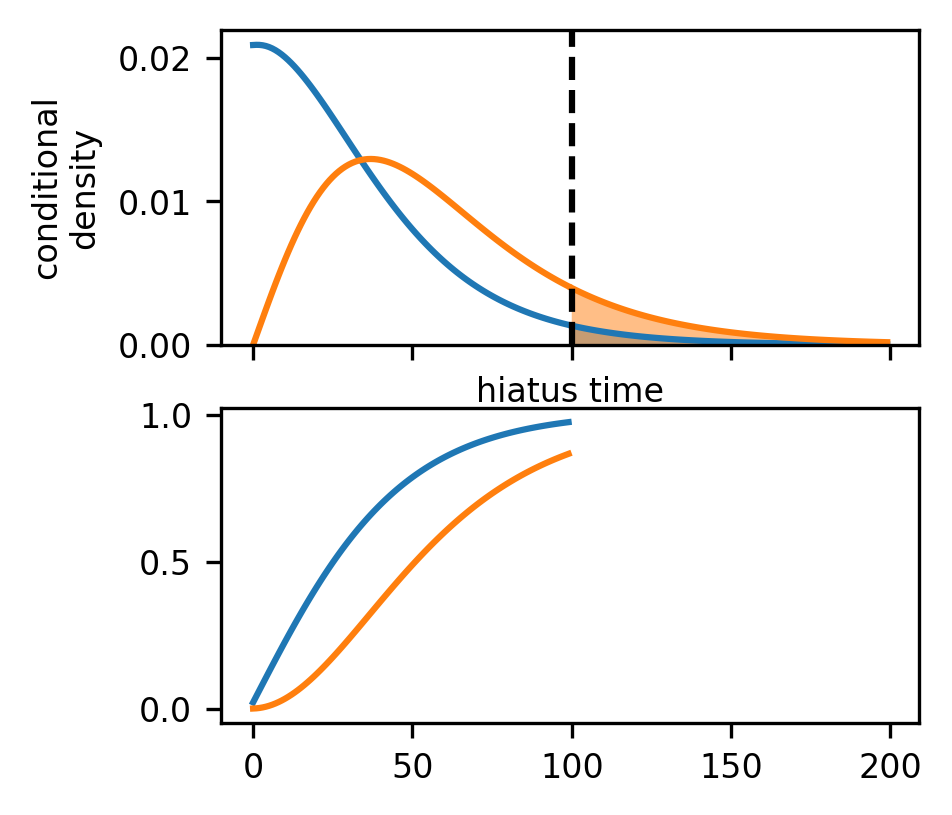

In [54]:
fig, AX = plt.subplots(2,1,figsize=(3, 3), sharex=True)
tau_vec1 = np.arange(0, tau, 1)
tau_vec2 = np.arange(tau, 200, 1)

ax = AX[0]
def f(tau):
    return combined_conditional_density(dist, t0, tau, params)


ax.plot(tau_vec1, [f(i_tau) for i_tau in tau_vec1])
ax.plot(tau_vec1, [length_biased_density(f, i_tau) for i_tau in tau_vec1])

vals = [f(i_tau) for i_tau in tau_vec2]
ax.fill_between(tau_vec2, vals, np.zeros_like(tau_vec2), alpha=0.5)
ax.plot(tau_vec2, vals, color="C0")

vals = [length_biased_density(f, i_tau) for i_tau in tau_vec2]
ax.fill_between(tau_vec2, vals, np.zeros_like(tau_vec2), alpha=0.5)
ax.plot(tau_vec2, vals, color="C1")

ax.set(xlabel="hiatus time", ylabel="conditional\ndensity", ylim=(0, ax.get_ylim()[1]))

ax.axvline(tau, color="k", ls="--")

ax = AX[1]

#  plot the corresponding cdfs
ax.plot(tau_vec1, np.cumsum(np.diff(tau_vec1)[0] * [f(i_tau) for i_tau in tau_vec1]))
ax.plot(tau_vec1, np.cumsum(np.diff(tau_vec1)[0] * [length_biased_density(f, i_tau) for i_tau in tau_vec1]))

In [55]:
print(scipy.integrate.quad(lambda tau: f(tau), tau, 1000, epsrel=1e-4)[0])
print(1-length_biased_conditional_probability(f, tau, 1e5))


0.035041412995767796
0.1310304530589408


0.852996985276645
0.8976229923035844
0.7565428412846417
0.6825170055865117
0.9561398195490348


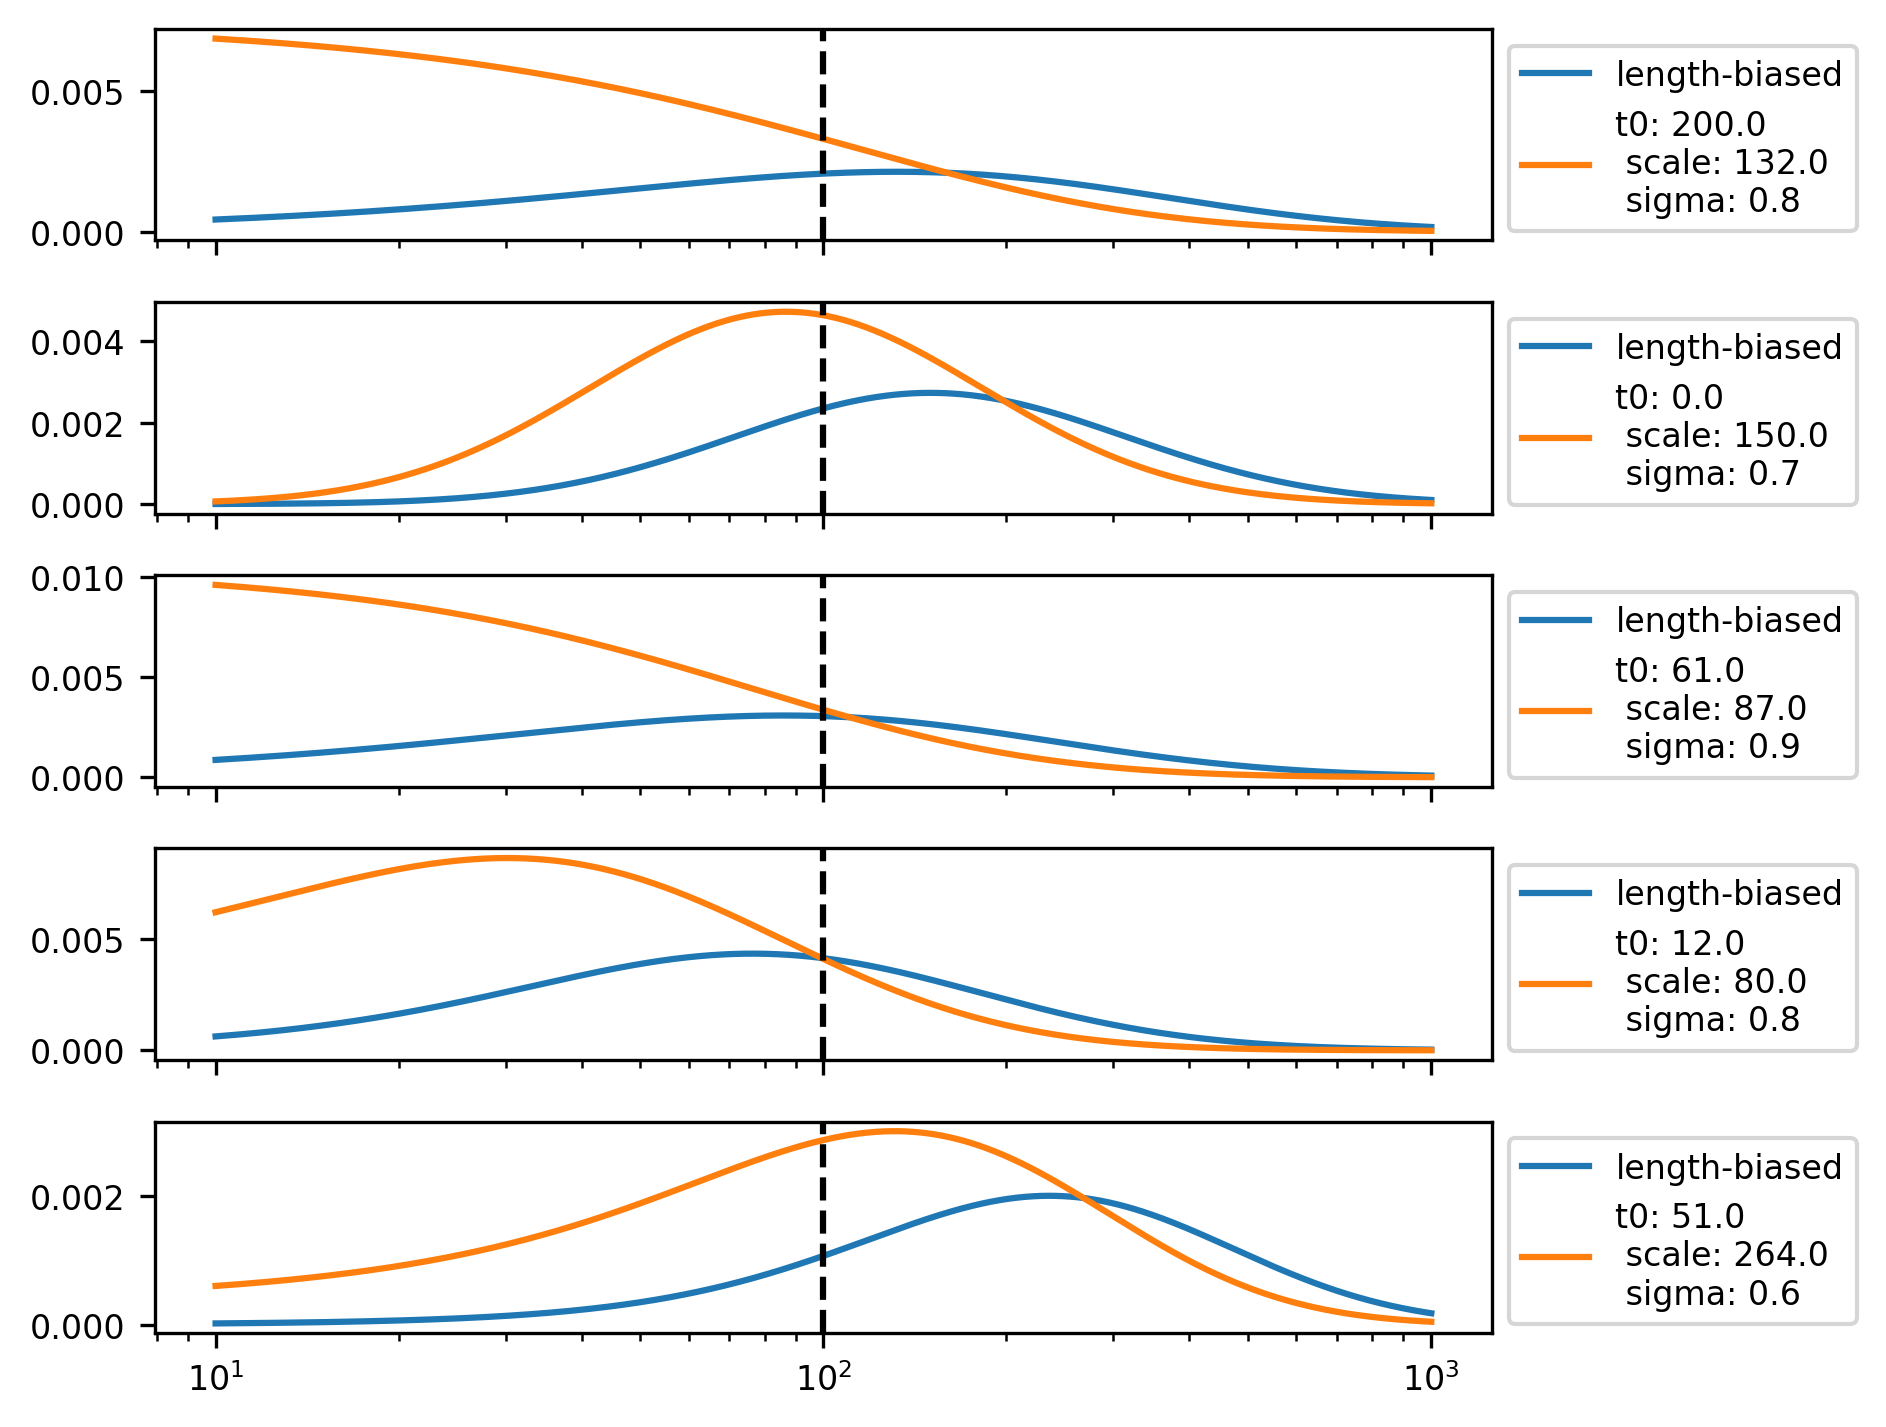

In [56]:
# length-biased corrected (site by site): log-normal
params_ln = [
    {"s": sigma, "scale": np.exp(mu)}
    for mu, sigma, selected in zip(mu, sigma, trench_selection)
    if selected
]

eps = 1e-6
t0 = np.array([t for t, selected in zip(t1.values, trench_selection) if selected]) + eps

fig, AX = plt.subplots(len(t0), 1, sharex=True)
for i, (i_t0, i_params) in enumerate(zip(t0, params_ln)):
    
    def f(tau):
        return conditional_density(dist, i_t0, tau, i_params)
    
    print(1-length_biased_conditional_probability(f,tau))
    
    t_array = np.logspace(np.log10(10),np.log10(1000),1000)
    AX[i].plot(t_array, length_biased_density(f,t_array), label=f"length-biased")
    AX[i].plot(t_array, f(t_array), label=f"t0: {i_t0:0.1f}\n scale: {i_params['scale']:0.1f}\n sigma: {i_params['s']:0.1f}")
    AX[i].set_xscale("log")
    AX[i].legend(bbox_to_anchor=(1, 1))
    AX[i].axvline(tau, color="k", ls="--")
    
plt.tight_layout()

In [57]:
def dot_line(ax, x1, x2, y, color="k", s=10):
    ax.plot([x1, x2], [y, y], color=color)
    ax.scatter(x1, y, facecolor="w", edgecolor=color, s=s, zorder=ax.get_lines()[-1].get_zorder() + 1)
    ax.scatter(x2, y, facecolor=color, edgecolor=color, s=s)

In [71]:
def plot_faults(
    ax=None, list_of_faults=["San Andreas", "Hayward", "San Jacinto", "Elsinore"]
):
    if ax is None:
        fig, ax = plt.subplots(
            figsize=(3, 4), subplot_kw={"projection": ccrs.PlateCarree()}
        )
    qfaults = src.qfaults.Qfaults(data_dir=Path(data_dir) / "Qfaults_GIS")

    qfaults.data.loc[qfaults.data["Location"] == "California", :].plot(ax=ax, color="slategray", alpha=0.8, linewidth=0.2)
    qfaults.plot_basemap(ax=ax)
    qfaults.data_offshore.plot(ax=ax, color="slategray", alpha=0.8, linewidth=0.2)

    fault_names = qfaults.data_onshore["fault_name"].unique()
    
    for fault in list_of_faults:
        bool = [fault in f for f in fault_names]
        name = fault_names[bool][0] # get all the faults that have `fault` in the name
        fault_name = qfaults.data_onshore[qfaults.data_onshore["fault_name"] == name]
        fault_name.plot(ax=ax, color="indianred", lw=1, alpha=1, zorder=2)
    
    fault_names = qfaults.data_offshore["FAULT_NAME"].unique()
    for fault in list_of_faults:
        bool = [fault in f for f in fault_names]
        if any(bool):
            name = fault_names[bool][0] # get all the faults that have `fault` in the name
            fault_name = qfaults.data_offshore[qfaults.data_offshore["FAULT_NAME"] == name]
            fault_name.plot(ax=ax, color="indianred", lw=1, alpha=1, zorder=2)

    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    plt.box(False)


I take all crosses corresponding to an intersection of the survival curves with 100 year mark as indication that the numerical calculation calculaiton matches the analytical calculaiton

### Todo

- [ ] add faults offshore 
- [ ] add key for the dot line plot

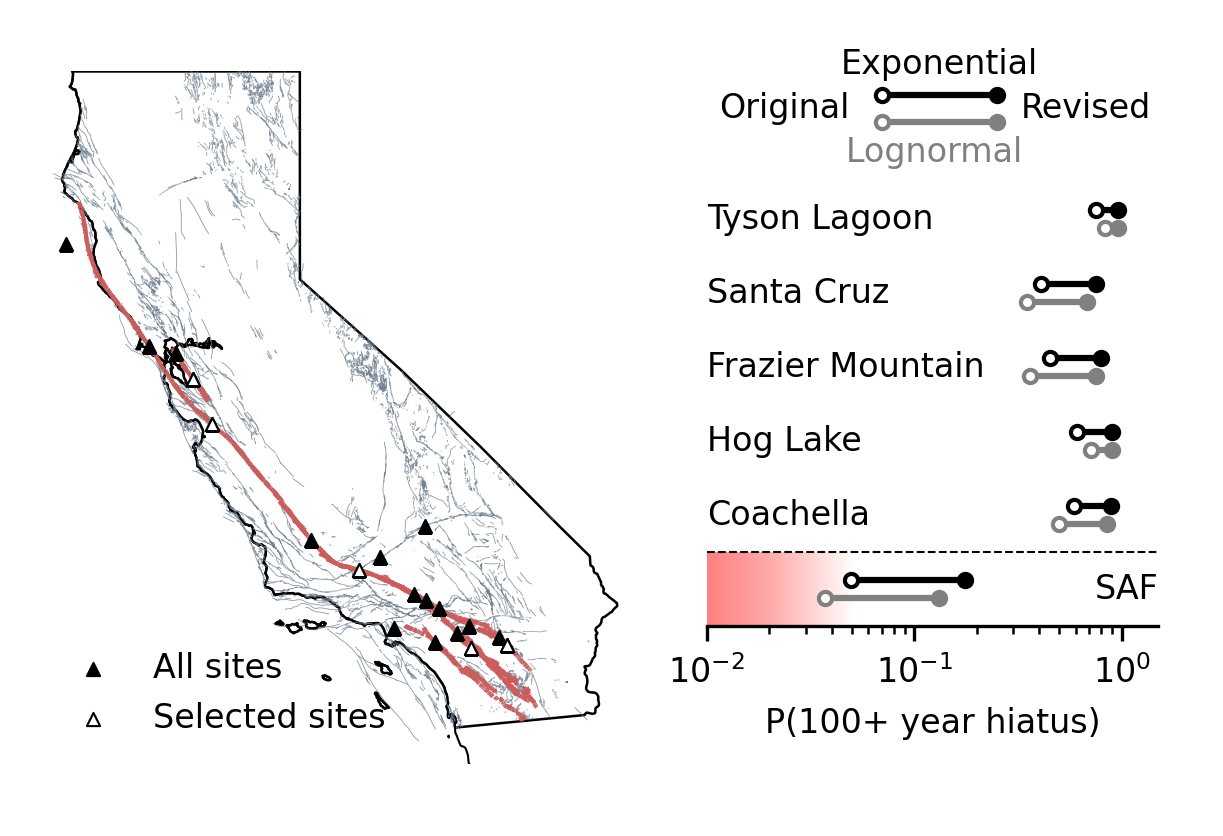

In [131]:
fig, ax = plt.subplots(figsize=(4, 3), subplot_kw={"projection": ccrs.PlateCarree()})
plot_faults(ax)
scatter_kwargs = dict(marker="^", s=10, linewidth=0.5, zorder=3)

ax.scatter(
    biasi_analysis["Longitude"],
    biasi_analysis["Latitude"],
    **scatter_kwargs,
    c="k",
    label="All sites",
)

ax.scatter(
    biasi_analysis["Longitude"][trench_selection],
    biasi_analysis["Latitude"][trench_selection],
    **scatter_kwargs,
    edgecolor="k",
    facecolor="w",
    label="Selected sites",
)
ax.legend(loc="lower left", fontsize=8, frameon=False)

########################################################


# Define inset box dimensions (relative to main axis)
inset_rect = [1.1, 0, 0.8, 1]  # [left, bottom, width, height] for a generous margin

# Create a white box with rounded corners and slate grey lines
bbox = mpl.patches.FancyBboxPatch(
    (inset_rect[0], inset_rect[1]),
    inset_rect[2],
    inset_rect[3],
    boxstyle="round,pad=0.06,rounding_size=0.01",
    edgecolor="slategray",
    facecolor="white",
    alpha=0.95,
    linewidth=0,
    zorder=4,
    transform=ax.transAxes,
    clip_on=False
)
ax.add_patch(bbox)

# Now make the inset axes inside this white box, with small insets for margin
margin = 0.025  # as a fraction of the width/height
left = inset_rect[0] + 2*margin * inset_rect[2]
bottom = inset_rect[1] + 8 * margin * inset_rect[3] 
width = inset_rect[2] - 2 * margin * inset_rect[2]
height = inset_rect[3] - 8 * margin * inset_rect[3]
inset_ax = ax.inset_axes([left, bottom, width, height], zorder=5)

shift = 0.125
colors = dict(
    exp="k",
    ln="grey",
)

biasi_hiatus_p_exp = (1 - biasi_analysis["EXP CP of Event in 100 Yr after 1918†"])[
    trench_selection
]

biasi_hiatus_p_ln = (1 - biasi_analysis["LN CP of Event in 100 Yr after 1918†"])[
    trench_selection
]

# length-biased corrected (site by site): exponential
lam = 1 / (biasi_analysis["EXP:\xa0\xa0(Yr)"][trench_selection])
revised_hiatus_p = (1 + 100 * lam) * np.exp(-100 * lam)


for i, (p1, p2) in enumerate(zip(biasi_hiatus_p_exp, revised_hiatus_p)):
    dot_line(inset_ax, p1, p2, i + 1+shift, colors["exp"])
    
net_hiatus_p = np.exp(-combined_rate * tau) * (combined_rate * tau + 1)
dot_line(inset_ax, biasi_hiatus_p_exp.prod(), net_hiatus_p, 0+shift, colors["exp"])

# length-biased corrected (site by site): log-normal
params_ln = [
    {"s": sigma, "scale": np.exp(mu)}
    for mu, sigma, selected in zip(mu, sigma, trench_selection)
    if selected
]

eps = 1e-6
t0 = np.array([t for t, selected in zip(t1.values, trench_selection) if selected]) + eps
for i, (p1, i_t0, i_params) in enumerate(zip(biasi_hiatus_p_ln, t0, params_ln)):
    def f(tau):
        return conditional_density(dist, i_t0, tau, i_params)
    
    p2 = 1-length_biased_conditional_probability(f, tau)
    dot_line(inset_ax, p1, p2, i + 1 - shift, colors["ln"])
    
def f(tau):
    return combined_conditional_density(dist, t0, tau, params_ln)

net_hiatus_p = 1-length_biased_conditional_probability(f, tau)
dot_line(inset_ax, biasi_hiatus_p_ln.prod(), net_hiatus_p, 0-shift, colors["ln"])
inset_ax.text(1.5, 0, "SAF", ha="right", va="center", fontsize=8)

########################################################

inset_ax.axhline(0.5, c="k", lw=0.5, ls="--")
yticklabels = ["Combined"]
for site in biasi_analysis["Site Code"][trench_selection]:
    yticklabels.append(site)
    
# add shading to indicate increasingly low probability of hiatus under model
n = 50
for i in range(n):
    inset_ax.axhspan(-0.5, 0.5, 0, i / 3 / n, facecolor="r", alpha=0.01, lw=0)

inset_ax.set(
    xlim=(0.01, 1.5),
    xscale="log",
    xlabel="P(100+ year hiatus)",
    ylim=(-0.5, len(yticklabels)+1),
    yticks=[],
)

for i, site in enumerate(biasi_analysis["Site*"][trench_selection]):
    inset_ax.text(0.01, i + 1, site, ha="left", va="center", fontsize=8)

inset_ax.spines["left"].set_visible(False)
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)


# manual legend:

left, right, y = 0.07, 0.25, len(biasi_hiatus_p_exp)+1.5
dot_line(inset_ax, left, right, y+shift*1.5, color=colors["exp"], s=10)
dot_line(inset_ax, left, right, y-shift*1.5, color=colors["ln"], s=10)

inset_ax.text(np.sqrt(left*right), y+shift*3, "Exponential", ha="center", va="bottom", fontsize=8, color=colors["exp"])
inset_ax.text(np.sqrt(left*right), y-shift*3, "Lognormal ", ha="center", va="top", fontsize=8, color=colors["ln"])
inset_ax.text(left*0.7, y, "Original", ha="right", va="center", fontsize=8)
inset_ax.text(right*1.3, y, "Revised", ha="left", va="center", fontsize=8)

plt.savefig("biasi_revised_comparison.pdf", dpi=300, bbox_inches="tight")